In [0]:
%tensorflow_version 2.x # selecting tensorflow version

!sudo pip install --upgrade pip;
!sudo pip install --upgrade tensorflow;

## Στοιχεία Ομάδας

Αριθμός Ομάδας: Μ.Α.11

    > Καρυπιάδης Ευστράτιος: 03114911

---

## Σύνολο Δεδομένων CIFAR-100

Το σύνολο δεδομένων στο οποίο θα εργαστούμε είναι το [CIFAR-100](https://bit.ly/38CUquZ), το οποίο αποτελείται απο 60.000 έγχρωμες εικόνες διαστάσεων 32x32. Κάθε μία από αυτές ανήκει σε μία γενική(*fine*) και μία ειδική(*coarse*) κατηγορία του συνόλου, πλήθους 100 και 20 αντίστοιχα. Προς ταξινόμηση των δειγμάτων μας θα εκμεταλευτούμε μονάχα τις *fine* κατηγορίες των εικόνων που έχουμε στη διάθεσή μας.

	

### Εισαγωγή συνόλου δεδομένων

In [0]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# loading the entire dataset
(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

Για τους σκοπούς της άσκησης **δε** θα εκμεταλλευτούμε ολόκληρο το σύνολο δεδομένων, αλλά θα δουλέψουμε σε ένα υποσύνολο αυτού σύμφώνα με τον αύξοντα αριθμό της ομάδας μας, `team_seed`. Στη συνέχεια υλοποιούμε μία σειρά βοηθητικών συναρτήσεων που θα μας βοηθήσουν σε αυτόν το διαχωρισμό:

In [0]:
def select_from_list(from_list, index_list):
  """ Return from_list elemenents according to index contained in index_list. """
  filtered_list= [from_list[i] for i in index_list]
  return(filtered_list)

def get_ds_index(unfiliterd_list, target_list):
  """ Append in filtered_list the index of each element in unfiltered_list if it exists in target_list. """
  index = 0
  filtered_list=[]
  for i_ in unfiliterd_list:
    if i_[0] in target_list:
      filtered_list.append(index)
    index += 1
  return(filtered_list)

def select_classes_number(classes_number = 20):
  """ Select unique subset of CIFAR-100 with classes_number of classes. """
  if classes_number == 20:
    return "https://bit.ly/3b3Cewb"
  elif classes_number == 40:
    return "https://bit.ly/3aPo819"
  elif classes_number == 60:
    return "https://bit.ly/2Wbo47K"
  elif classes_number == 80:
    return "https://bit.ly/38NDW3d"
  else:
    return -1

### Διαχωρισμός δεδομένων εκπαίδευσης - ελέγχου

Στο επόμενο κελί επιλέγουμε το πλήθος των κατηγοριών με το οποίο επιθυμούμε να δουλέψουμε:

In [0]:
cifar100_classes_url = select_classes_number() # default: 20 classes

Δημιουργούμε το μοναδικό dataset της ομάδας μας:

In [0]:
team_seed = 11 # team_seed number

team_classes = pd.read_csv(cifar100_classes_url, sep=',', header=None) # fetch class indexes
CIFAR100_LABELS_LIST = pd.read_csv("https://bit.ly/3cRO3qZ", sep=',', header=None).astype(str).values.tolist()[0] # fetch class names

our_index = team_classes.iloc[team_seed, :].values.tolist() # select team class indices
our_classes = select_from_list(CIFAR100_LABELS_LIST, our_index) # select team class names

train_index = get_ds_index(y_train_all, our_index)
test_index = get_ds_index(y_test_all, our_index)

# Train data and labels
x_train_ds = np.asarray(select_from_list(x_train_all, train_index))
y_train_ds = np.asarray(select_from_list(y_train_all, train_index))

# Test data and labels
x_test_ds = np.asarray(select_from_list(x_test_all, test_index))
y_test_ds = np.asarray(select_from_list(y_test_all, test_index))

Μετά την παραπάνω διαδικασία εμφανίζουμε τα ονόματα των κατηγοριών που αντιστοιχούν στην ομάδα μας:

In [6]:
print(our_classes)

['apple', ' aquarium_fish', ' bicycle', ' boy', ' couch', ' flatfish', ' kangaroo', ' leopard', ' lion', ' mouse', ' mushroom', ' orchid', ' plain', ' plate', ' skunk', ' streetcar', ' sunflower', ' table', ' telephone', ' tulip']


### Επισκόπηση δεδομένων και κανονικοποίηση

Τέλος, για καλύτερη εποπτεία του συνόλου δεδομένων μας θα εξάγουμε ορισμένες χρήσιμες πληροφορίες για αυτό, ενώ παράλληλα θα κανονικοποιήσουμε τις τιμές αναπαράστασης των εικόνων:

In [8]:
data_size, img_rows, img_cols, img_channels = x_train_ds.shape # get train dataset dimensions

# Set validation set percentage
validation_percentage = 0.15
val_size = round(validation_percentage * data_size)

# Reserve val_size samples for validation and normalize all values
x_val = x_train_ds[-val_size:]/255
y_val = y_train_ds[-val_size:]
x_train = x_train_ds[:-val_size]/255
y_train = y_train_ds[:-val_size]
x_test = x_test_ds/255
y_test = y_test_ds

# Summarize loaded dataset
print('Train:       X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Validation:  X=%s, y=%s' % (x_val.shape, y_val.shape))
print('Test:        X=%s, y=%s' % (x_test.shape, y_test.shape))

Train:       X=(8500, 32, 32, 3), y=(8500, 1)
Validation:  X=(1500, 32, 32, 3), y=(1500, 1)
Test:        X=(2000, 32, 32, 3), y=(2000, 1)


---

## Συναρτήσεις Προετοιμασίας Δεδομένων και Οπτικοποίησης Απόδοσης

Στη συνέχεια θα υλοποιήσουμε απαραίτητες συναρτήσεις προετοιμασίας των δεδομένων για εκπαίδευση, καθώς και οπτικοποίσης της τελικής απόδοσης των μοντέλων που πρόκειται να δοκιμάσουμε.

### Συναρτήσεις Εκπαίδευσης

Αρχικά θα υλοποιήσουμε την `_input_fn`, η οποία αποτελεί ένα *pipeline* που θα προετοιμάσει τα δεδομένα μας για την εκπαίδευση. Πιο συγκεκριμένα, χρησιμοποιούμε τις μεθόδους `shuffle`, `repeat` και `batch` της [tf.data.Dataset](https://bit.ly/2vk7EPr), ώστε να δημιουργήσουμε υποσύνολα 128 δειγμάτων, τα οποία ελήφθησαν τυχαίως από το ολικό μας σύνολο. Σημειώνουμε ότι η μέθοδος `repeat` είναι απαραίτητη για να αντιμετωπίσουμε τυχόν σφάλμα που θα προκύψει, εάν η μέθοδος `batch` επιχειρήσει να δημιουργήσει εκ νέου υποσύνολο, αφού έχει ομαδοποιήσει όλα τα διαθέσιμα δείγματα του συνόλου. 

Παρατηρούμε ότι η συνάρτηση επιστρέφει υποσύνολα δεδομένων `PrefetchDataset Objects`, μορφή η οποία επιταχύνει τη διαδικασία εκπαίδευσης, καθώς επιτρέπει το διάβασμα του επόμενου *batch* δεδομένων, ενώ παράλληλα εκπαιδεύεται το παρόν.

In [0]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE

def _input_fn(x, y, BATCH_SIZE):
  """ Returns shuffled and batched tensors in the form of PrefetchDataset objects. """
  ds = tf.data.Dataset.from_tensor_slices((x, y))
  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.repeat() # repeat indefinately
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

# PrefetchDataset objects
train_ds =_input_fn(x_train, y_train, BATCH_SIZE)
validation_ds =_input_fn(x_val, y_val, BATCH_SIZE)
test_ds =_input_fn(x_test, y_test, BATCH_SIZE)

Στη συνέχεια υλοποιούμε τη συνάρτηση `train_model`. Σημειώνουμε ότι με την παράμετρο `steps_per_epoch` μπορούμε να επιλέξουμε το πλήθος των *batches* στο οποίο επιθυμούμε να εκπαιδευτεί το μοντέλο μας πριν περάσει στην επόμενη εποχή.

In [0]:
def train_model(model, epochs, steps_per_epoch, validation_steps):
  """ Training function. """
  history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_ds, validation_steps=validation_steps)
  return(history)

### Γραφικές παραστάσεις εκπαίδευσης και απόδοση στο σύνολο ελέγχου

Τέλος, υλοποιούμε συναρτήσεις οπτικοποίησης της απόδοσης της εκπαίδευσης προς εξαγωγή χρήσιμων πληροφοριών και μελέτη των αποτελεσμάτων που θα προκύψουν από τη δοκιμή των μοντέλων μας.

In [0]:
def summarize_diagnostics(history):
	""" Plot diagnostic learning curves. """
	plt.figure(figsize=(8, 8))
	plt.suptitle('Training Curves')
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='val')
	plt.legend(loc='upper right')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='val')
	plt.legend(loc='lower right')
	return plt
 
def model_evaluation(model, evaluation_steps):
	""" Print test set and evaluation metrics. """
	print('\nTest set evaluation metrics')
	loss0,accuracy0 = model.evaluate(test_ds, steps=evaluation_steps)
	print("loss: {:.2f}".format(loss0))
	print("accuracy: {:.2f}".format(accuracy0))

def model_report(model, history, evaluation_steps = 10):
	plt = summarize_diagnostics(history)
	plt.show()
	model_evaluation(model, evaluation_steps)

## Μοντέλα δικτύων

### Ένα μικρό συνελικτικό δίκτυο "from scratch"

In [0]:
# a simple CNN https://www.tensorflow.org/tutorials/images/cnn

def init_simple_model(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(100, activation='softmax'))
  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [24]:
SIMPLE_MODEL = init_simple_model(summary = True)
SIMPLE_MODEL_history = train_model(SIMPLE_MODEL, 50, 30, 5)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)               

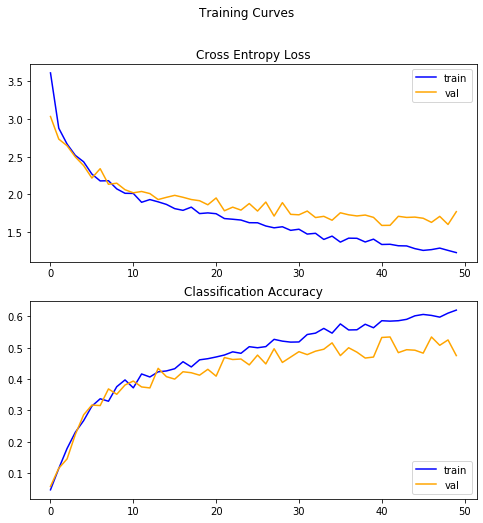


Test set evaluation metrics
30/30 [==============================] - 0s 6ms/step - loss: 1.6393 - accuracy: 0.5125
loss: 1.64
accuracy: 0.51


In [25]:
model_report(SIMPLE_MODEL, SIMPLE_MODEL_history, 30)

### Μεταφορά μάθησης: VGG16

In [0]:
# transfer learning: VGG16 trained on ImageNet without the top layer

def init_VGG16_model(summary):
  VGG16_MODEL=tf.keras.applications.VGG16(input_shape=(img_rows, img_cols, img_channels), include_top=False, weights='imagenet')

  # unfreeze conv layers
  VGG16_MODEL.trainable=True

  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([VGG16_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [0]:
VGG16_MODEL = init_VGG16_model(summary = True)
VGG16_MODEL_history = train_model(VGG16_MODEL, 25, 40, 10)

58892288/58889256 [==============================] - 5s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 512)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               51300     
Total params: 14,765,988
Trainable params: 14,765,988
Non-trainable params: 0
_________________________________________________________________
Train for 40 steps, validate for 10 steps
Epoch 1/25
40/40 [==============================] - 3s 86ms/step - loss: 3.2556 - accuracy: 0.2031 - val_loss: 1.7827 - val_accuracy:

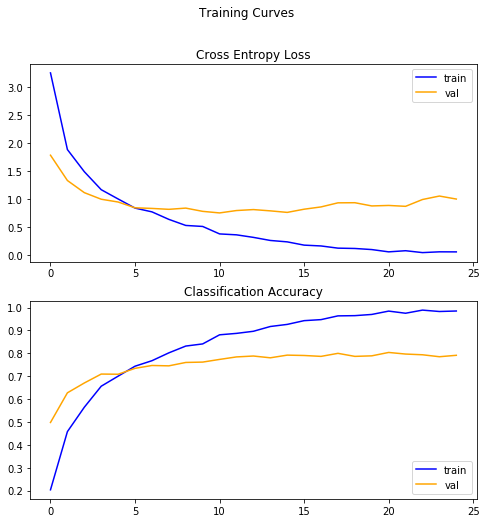


Test set evaluation metrics
30/30 [==============================] - 0s 14ms/step - loss: 1.0188 - accuracy: 0.7872
loss: 1.02
accuracy: 0.79


In [0]:
model_report(VGG16_MODEL, VGG16_MODEL_history, 30)

# Βελτίωση της επίδοσης με πειράματα

Καλείστε να βελτιώσετε τα αποτελέσματα ταξινόμησης στο CIFAR-100 και να βγάλατε συμπεράσματα, σύμφωνα με όσα ζητούνται σε σχέση με την αναφορά παράδοσης. 

## Δοκιμές διαφορετικών μοντέλων

Μπορείτε είτε να δοκιμάσετε μοντέλα "from scratch", όπου ορίζετε την αρχιτεκτονική του δικτύου όπως θέλετε, είτε να χρησιμοποιήσετε μεταφορά μάθησης.



### Μοντέλα "from scratch"

Μπορείτε να τροποποιήσετε/αλλάξετε το αρχικό μικρό συνελικτικό δίκτυο του παραδείγματος. Μπορείτε να συμβουλευτείτε 
- τη [βιβλιογραφία απο το leaderboard του CIFAR-100](https://benchmarks.ai/cifar-100) για αρχιτεκτονικές και παραμέτρους των δικτύων
- ή/και να πάρετε ιδέες [από σχετική αναζήτηση στο Google Scholar](https://scholar.google.gr/scholar?hl=en&as_sdt=0%2C5&q=cifar+100+cnn&oq=cifa)

### Μεταφορά μάθησης

Εναλλακτικά, μπορείτε να χρησιμοποιήσετ τη [μεταφορά μάθησης του tf2](https://www.tensorflow.org/tutorials/images/transfer_learning). Σε αντίθεση με τα μοντέλα "from scratch" η μεταφορά μάθησης μας επιστρέφει έτοιμα μοντέλα με προκαθορισμένη αρχιτεκτονική στην οποία μπορούμε γενικά μόνο να προσθέσουμε επίπεδα, τα οποία συνήθως περιορίζοντα σε πλήρως διασυνδεδεμένα επίπεδα που εξειδικεύονται στο συγκεκριμένο task ταξινόμησης που έχουμε να επιτελέσουμε. 

#### Εκπαίδευση βαρών

Ταυτόχρονα με την αρχιτεκτονική, στη μεταφορά μάθησης εισάγουμε και τη γνώση που έχει αποκτήσει το μοντέλο, δηλαδή τις τιμές των βαρών του όπως έχουν προκύψει μετά από εκπαίδευση συνήθως στο (τεράστιο) ImageNet. Οταν εισάγουμε ένα μοντέλο με μεταφορά μάθησης έχουμε τρεις επιλογές για την εκπαίδευση:
- να παγώσουμε τη συνελικτική βάση και να εκπαιδεύσουμε την κεφαλή ταξινόμησης (classification head). Αυτό αντιστοιχεί στο να χρησιμοποιήσουμε τη συνελικτική βάση για εξαγωγή χαρακτηριστικών (feature extraction), σημαία trainable = False.
- να συνεχίσουμε να εκπαιδεύουμε όλα τα επίπεδα του δικτύου, σημαία trainable = True.
- να εκπαιδευτεί μόνο ένα ποσοστό των επιπέδων, εβρισκόμενο προς την έξοδο του δικτύου. Οι σημαίες trainable εδώ θα πρέπει να οριστούν ανά επίπεδο.



#### Διαθέσιμα μοντέλα για μεταφορά μάθησης στο tf2

1. tf.keras.applications. Ο πιο απλός τρόπος για να κάνουμε μεταφορά μάθησης στο tf2 είναι μέσω του [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications) που παρέχει προεκπαιδευμένα μοντέλα από το Keras και συγκεκριμένα τα δίκτυα: DenseNet, Inception-ResNet V2, Inception V3, MobileNet v1, MobileNet v2, NASNet-A, ResNet, ResNet v2, VGG16, VGG19 και Xception V1. Η εισαγωγή των μοντέλων γίνεται παρόμοια με αυτή που δείξαμε παραπάνω για το VGG16.

2. TensorFlow Hub. Μπορείτε επίσης να χρησιμοποιήσετε μοντέλα τα οποία είναι διαθέσιμα στο αποθετήριο [TensoFlow Hub](https://tfhub.dev/s?fine-tunable=yes&module-type=image-augmentation,image-classification,image-feature-vector,image-generator,image-object-detection,image-others,image-style-transfer,image-rnn-agent&tf-version=tf2) το οποίο περιλαμβάνει πάνω από 100 προεκπαιδευμένα μοντέλα.

3. Αποθηκευμένα μοντέλα απο τρίτες πηγές. Μπορείτε επίσης να κάνετε μεταφορά μάθησης από τρίτες πηγές, είτε του συνόλου του νευρωνικού, αρχιτεκτονικής και βαρών, είτε μόνο της αρχιτεκτονικής ή των βαρών. Το μοντέλο θα πρέπει να έχει αποθηκευθεί σε ένα από τα δύο φορμάτ, Keras HDF5 format (.h5 ή .keras) ή ως στο SavedModel format που αναφέραμε στην εισαγωγή. Τα βάρη μπορούν να εισαχθούν και μόνα τους ως Checkpoints. Για περισσότερα, διαβάστε σχετικά τα λήμματα ["Save and load models"](https://www.tensorflow.org/tutorials/keras/save_and_load), ["Save and serialize"](https://www.tensorflow.org/guide/keras/save_and_serialize), ["Using the SavedModel format"](https://www.tensorflow.org/guide/saved_model) και δείτε για παράδειγμα πως μπορούμε να κάνουμε μεταφορά μάθησης από τα state-of-the-art EfficientNets ([1](https://www.dlology.com/blog/transfer-learning-with-efficientnet/), [2](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnethttps://)).

Σημειώστε ότι πολλά μοντέλα απαιτούν μεγαλύτερες διαστάσεις στην είσοδο από αυτές του CIFAR-100 και κατά συνέπεια τα δεδομένα πρέπει να [μετασχηματιστούν](https://www.tensorflow.org/api_docs/python/tf/image/resize). Προσέξτε ωστόσο τις απαιτήσεις σε μνήμη όταν αυτοί οι μετασχηματισμοί γίνονται απευθείας σε μεταβλητές (βλ. πιο κάτω "Διαχείριση μνήμης"). 


## Παρατηρήσεις ως προς τη βελτιστοποίηση

### Διαχείριση μνήμης (TFRecord)

Η φόρτωση δεδομένων με τον τρόπο που το κάναμε παραπάνω στο απλό παράδειγμα υλοποίησης είναι πολύ βολική αλλά δεν είναι καθόλου αποτελεσματική ως προς τη διαχείριση της μνήμης. Συγκεκριμένα, με τον τρόπο αυτό, τα δεδομένα αποθηκεύονται απευθείας σε μεταβλητές, οι οποίες όλες μαζί καταλαμβάνουν τη RAM της CPU ή της GPU, κάτι που κάνει αδύνατη τη διαχείριση μεγάλων datasets ή τον μεταχηματισμό των δεδομένων όπως όταν κάνουμε αύξηση δεδομένων (data augmentation).

Για να παρακαμφθεί αυτό το πρόβλημα, υπάρχει η δυνατότητα της σειριοποίησης των δεδομένων (serialization) και της αποθήκευσής τους σε αρχεία μεσαίου μεγέθους (κάποιων MB) τα οποία μπορούνα να αναγνωστούν γραμμικά. Το φορμάτ TFRecord είναι ένα φορμάτ που επιτρέπει την αποθήκευση σειράς δυαδικών εγγραφών. Διαβάστε τα σχετικά λήμματα [TFRecord and tf.Example](https://www.tensorflow.org/tutorials/load_data/tfrecord) και [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data). 

Σημειώστε ότι με τη μέθοδο αυτή θα πρέπει να γίνει import η `tensorflow_datasets` και να χρησιμοποιήσουμε την `tfds.load` ώστε να αποθηκευθεί το σύνολο δεδομένων σε αρχεία tfrecord στο δίσκο (δείτε [εδώ](https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/overview.ipynb) ένα παράδειγμα). Φυσικά μπορούμε να μετατρέψουμε και τα πρωτογενή δεδομένα (raw data) του dataset όπως αρχεία jpg σε φορματ tfrecord όπως [εδώ](https://towardsdatascience.com/working-with-tfrecords-and-tf-train-example-36d111b3ff4d).



### Υπερεκπαίδευση

Μπορείτε να πειραματιστείτε ως προς τον έλεγχο της υπερεκπαίδευσης (overfitting) με διάφορους τρόπους. Μεταξύ αυτών μπορούμε να αναφέρουμε τους εξής:
- Πρόωρος τερματισμός (early stopping). Μια μέθοδος που τερματίζει την εκπαίδευση αν δεν υπάρχει βελτίωση ως προς τη μετρική απόδοσης που παρακολουθούμε. [tf.keras.callbacks.EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStoppinghttps://)
- Dropout. Μια άλλη τεχνική για τη μείωση της υπερεκπαίδευσης είναι το Dropout. Είναι ένα είδος ομαλοποίησης (regularization) που επιβάλλει στα βάρη του δικτύου να παίρνουν μόνο μικρές τιμές. Εάν εφαρμόσουε dropout σε ένα επίπεδο του δικτύου, τότε ένα ποσοστό των βαρών του γίνεται τυχαία μηδενικό κατά την εκπαίδευση. [Dropout](https://www.tensorflow.org/tutorials/images/classification#dropout)
- Επαύξηση δεδομένων. Η υπερεκπαίδευση συνήθως συμβαίνει όταν έχουμε λίγα ή/και πολύ όμοια δεδομένα εκπαίδευσης. Ένας τρόπος να διορθωθεί αυτό το πρόβλημα είναι να αυξήσουμε τα δεδομένα (data augmentation). Το data augmentation δημιουργεί νέα δεδομένα εκπαίδευσης με βάση τα υπάρχοντα εφαρμόζοντας τυχαίους μετασχηματισμούς ώστε να προκύπτουν αληθοφανείς εικόνες. [Data augmentation](https://www.tensorflow.org/tutorials/images/classification#data_augmentation), [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#class_imagedatagenerator)

Βλέπε επίσης [Image classification](https://www.tensorflow.org/tutorials/images/classification).

### Χρόνος εκπαίδευσης

Το TensorFlow 2 προσφέρει νέους ή βελτιώνει διάφορους μηχανισμούς βελτιστοποίησης της εκπαίδευσης. Μεταξύ αυτών έχουμε τους εξής:
- Data prefetching (το χρησιμοποιήσαμε παραπάνω)
- Data reading parallelization 
- Map transformation parallelization
- Caching
- Reducing memory footprint

Συμβουλευτείτε για τα παραπάνω το [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance)

### Εργαλεία υψηλού επιπέδου

Μεταξύ των εργαλείων βελτιστοποίησης υψηλού επιπέδου (high-level) του TensorFlow μπορούμε να αναφέρουμε τα ακόλουθα:

- [TensorBoard](https://www.tensorflow.org/tensorboard/get_started) και [What-If Tool](https://www.tensorflow.org/tensorboard/what_if_tool) Επικουρικό εργαλείο οπτικοποίησης για τον πειραματισμό στη Μηχανική Μάθηση
- [tf-explain](https://tf-explain.readthedocs.io/en/latest/) Προσφέρει μεθόδους επεξηγισιμότητας για το tf2
- [Keras Tuner](https://github.com/keras-team/keras-tuner) Βελτιστοποίηση υπερπαραμέτρων του Keras στο TensorFlow 2.0
- [AutoAugment](https://github.com/tensorflow/models/tree/master/research/autoaugment) Εκμάθηση της πολιτικης επαύξησης από τα δεδομένα